**Week 10: Markovian Langevin Dynamics and Diffusion**

Jannek Schaffert, Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**

In this excercise a Langevian Integrator (LE) with Markovian dynamics is implemented.



**Task 1: Implementation**

equation:
$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \Gamma \vec{v}_k \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right);
$

with

$
\vec{x}_{k+1} = \vec{x}_k + \vec{v}_k \Delta t
$.

With $k$ denoting the step number, $\Delta t$ the time step length, $U$ the potential energy, $x$ the position, $v$ the velocity, and a friction constant $\Gamma$.




Importing all libraries used in this code.


In [31]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit

import copy
import numpy as np
import scipy as scy
from tqdm import tqdm
import time
# Import tqdm


**Task 2 - LE Simulation**

A particle with a mass of $m = 18$g/ mol and a starting velocity corresponding to a temperature of $T = 293.15$K in a random direction is assigned to the particle.
The potential energy is set a constant throughout the box. This changes our LE integrator. TO observe this, first we need to rewrite the Langevian equation with potential energy $U$:

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \frac{dU}{dx} \Delta t + \vec{v}_k \Gamma \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right)
$

Since the Potential is set to a constant the equation simplifies to

$
\vec{v}_{k+1} = \vec{v}_k - \frac{1}{m} \left( \vec{v}_k \Gamma \Delta t - \sqrt{2 \Gamma k_B T \Delta t} \cdot \vec{R}_k \right)
$

and

$
\vec{x}_{k+1} = \vec{x}_k + \vec{v}_k \Delta t
$

.


In [35]:

def langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, k_B=1.380649e-23, verbose=False):

    # Start timer
    start_time = time.time()

    # Initialize position and velocity arrays
    positions = np.zeros((steps, len(x0)))
    velocities = np.zeros((steps, len(v0)))

    # Set initial position and velocity
    positions[0] = x0
    velocities[0] = v0

    # Loop over steps
    for i in tqdm(range(steps - 1), desc="Running Langevin Integrator", unit="steps"):
        # Generate Gaussian random noise
        R = np.random.normal(0, 1, size=x0.shape)

        # Current velocity and position
        v = velocities[i]
        x = positions[i]

        # Update velocity and position
        v_next = v - (gamma / mass) * v * dt + np.sqrt(2 * gamma * k_B * temp * dt) / mass * R
        x_next = x + v_next * dt

        # Store the updated values
        velocities[i + 1] = v_next
        positions[i + 1] = x_next

        # Verbose logging
        if verbose and i % 100 == 0:
            print(f"Step {i}: Position = {x_next}, Velocity = {v_next}")

    # End timer and print elapsed time
    end_time = time.time()
    print(f"Time elapsed: {end_time - start_time} seconds")

    return positions, velocities

In [36]:
# Example Parameters
steps = 1000000 # 1 Mio
dt = 1.0e-6 # ns
x0 = np.array([0.0, 0.0])  # Initial position (2D) in nm
v0 = np.array([0.0, 0.0])  # Initial velocity (2D)
mass = 0.018  # kg/mol
gamma = 50  # Friction constant from sheet
temp = 293.15  # Kelvin

# Run simulation
positions, velocities = langevin_integrator(steps, dt, x0, v0, mass, gamma, temp, verbose=False)



Running Langevin Integrator: 100%|██████████| 999999/999999 [00:13<00:00, 76709.02steps/s]

Time elapsed: 13.063971042633057 seconds


Plotting the position evolution from the simulation.

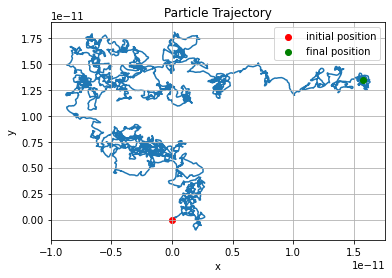

In [37]:

plt.plot(positions[:, 0], positions[:, 1], zorder=0)
plt.scatter(positions[0,0], positions[0,1], label="initial position", color="red", zorder=1)
plt.scatter(positions[-1,0], positions[-1,1], label="final position", color="green", zorder=1)
plt.title("Particle Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()



**Task 3 - Determination of diffusion coefficient**

The 2D diffusion coefficient is calculated:

$
D(t) = \Delta \vec{x}(t)^2 / 4t
$